In [6]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.stats import norm,kstest,shapiro,t
import pylab
import time
import warnings
import seaborn as sns
import statistics
import scipy.stats
import scipy.optimize as optimize
import yfinance as yf

In [5]:
pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 62 kB 1.4 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0


# Problem1

In [ ]:
def simulate_path(method, start_price, sigma, sample_size):
  return0 = scipy.stats.norm(0, sigma).rvs(sample_size)
  price_arr = []
  if method == "Classical":
    for i in range(0, sample_size):
      price = start_price + return0[i]
      price_arr.append(price)
    expected_mean = start_price
    expected_variance = sigma
  elif method == "Arithemetic":
    for i in range(0, sample_size):
      price = start_price * (1 + return0[i])
      price_arr.append(price)
    expected_mean = start_price
    expected_variance = start_price * sigma
  elif method == "Geometric":
    for i in range(0, sample_size):
      price = start_price * np.exp(return0[i])
      price_arr.append(np.log(price))
    expected_mean = np.log(start_price)
    expected_variance = sigma
  else:
    print("Wrong method!")
  return price_arr, expected_mean, expected_variance

In [ ]:
return0 = scipy.stats.norm(0, 0.1).rvs(10000)
return0.mean()

-0.001075855559840899

In [ ]:
def show_simulation_results(method, start_price, sigma, sample_size):
  price_path, expected_mean, expected_sigma = simulate_path(method, start_price, sigma, sample_size)
  #print(price_path)
  print(f"{method}")
  print(f"\tsimulate_mean = {np.mean(price_path):.2f}, expected_mean = {expected_mean:.2f}")
  print(f"\tsimulate_standard_deviation = {np.std(price_path):.2f}, expected_sigma = {expected_sigma:.2f}")
  plt.figure(dpi=120)
  sns.set(style='dark')
  sns.set_style("dark", {"axes.facecolor": "#e9f3ea"})
  g=sns.distplot(price_path, hist=True, kde=True, kde_kws={'linestyle':'--','linewidth':'1','color':'#098154'})
  return

Classical
	simulate_mean = 100.00, expected_mean = 100.00
	simulate_standard_deviation = 0.10, expected_sigma = 0.10


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


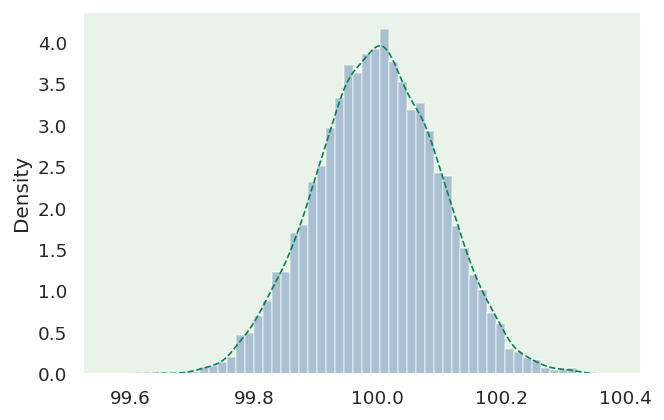

In [ ]:
show_simulation_results("Classical", 100, 0.1, 10000)

Arithemetic
	simulate_mean = 99.98, expected_mean = 100.00
	simulate_standard_deviation = 10.04, expected_sigma = 10.00


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


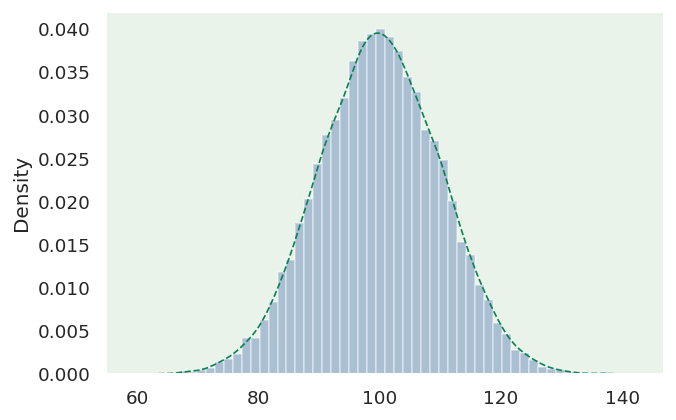

In [ ]:
show_simulation_results("Arithemetic", 100, 0.1, 10000)

Geometric
	simulate_mean = 4.60, expected_mean = 4.61
	simulate_standard_deviation = 0.10, expected_sigma = 0.10


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


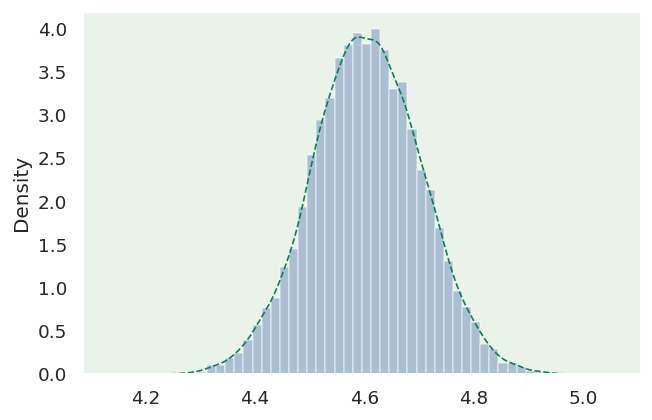

In [ ]:
show_simulation_results("Geometric", 100, 0.1, 10000)

# Problem2

Calculate return

In [ ]:
def cal_return(method, arr):
  return_arr = []
  if method == "Arithemetic":
    for i in range(1, len(arr)):
      return0 = arr[i] / arr[i-1]
      return_arr.append(return0 - 1)
  elif method == "Geometric":
    for i in range(0, len(arr)):
      return0 = arr[i] / arr[i-1]
      return_arr.append(np.log(return0))
  return np.array(return_arr)

In [ ]:
df = pd.read_csv("DailyPrices.csv")

In [ ]:
return0 = cal_return("Arithemetic", df["INTC"])
return0 -= return0.mean()
return_set = pd.DataFrame(return0)

In [ ]:
def cal_adj_weights(lambda0, df):
  X = df.index.values
  weights = [(1-lambda0) * lambda0 ** (i-1) for i in X]
  adj_weights = [weights[i] / sum(weights) for i in X]
  return adj_weights

In [ ]:
def cal_cov(x, y, weights):
  n = len(weights)
  mean_x = np.mean(x)
  mean_y = np.mean(y)
  cov = 0
  for i in range(n):
    cov += weights[n - 1 - i]*(x[i] - mean_x) * (y[i] - mean_y)
  return cov

In [ ]:
def simulate_normal(df, alpha, sample_size):
  sigma = df.std()
  normal = np.random.normal(0,sigma,size=sample_size)
  VaR = -np.percentile(normal, alpha)
  print(f"Normal distribution VaR: {round(VaR*100,2)}%")
  return VaR, normal

In [ ]:
def simulate_EW(df, lambda0, alpha, sample_size):
  temp = return_set.reset_index()
  adj_weights = cal_adj_weights(lambda0, temp)
  sigma = np.sqrt(cal_cov(df.values, df.values, adj_weights))
  Weighted_normal = np.random.normal(0, sigma, 10000)
  VaR = -np.percentile(Weighted_normal,5)
  print(f"Exponentially Weighted Normal VaR: {round(VaR*100,2)}%")
  return VaR, Weighted_normal

In [ ]:
Weighted_Normal_VaR = simulate_EW(return_set, 0.94, 5, 10000)

Exponentially Weighted Normal VaR: 2.55%


In [ ]:
def MLE_t(array):
  def t_log_lik(par_vec, x):
    lik = -np.log(t(df=par_vec[0], loc=par_vec[1], scale=par_vec[2]).pdf(x)).sum()
    return lik
  cons = ({'type': 'ineq', 'fun': lambda x: x[0] - 2},{'type': 'ineq', 'fun': lambda x: x[2]})
  df, mean, scale = optimize.minimize(fun=t_log_lik, x0=[2, np.array(array).mean(), np.array(array).std()], constraints=cons, args=(np.array(array))).x
  return df, mean, scale

def simulate_MLE_t(df, alpha, sample_size):
  t_params = MLE_t(return_set)
  simulation_t =  t.rvs(df = t_params[0], loc = t_params[1], scale = t_params[2], size = sample_size)
  VaR = -np.percentile(simulation_t,alpha)
  print(f"T distribution VaR: {round(VaR*100,2)}%")
  return VaR, simulation_t

In [ ]:
def simulate_history(df, alpha):
  VaR = -np.percentile(df,5)
  print(f"Historic Simulation VaR: {round(VaR*100,2)}%")
  return VaR

In [ ]:
def get_out_of_sample(stock, start_date, end_date):
  intc_df = yf.download(stock, start=start_date, end=end_date, progress=False)
  intc_df = intc_df["Adj Close"]
  ret_oos = cal_return("Arithemetic", intc_df)
  ret_oos -= ret_oos.mean()
  ret_oos = pd.DataFrame(ret_oos)
  return ret_oos

In [ ]:
return_oos = get_out_of_sample('INTC', '2022-01-15', '2022-04-15')

In [ ]:
def show_simulation_results1(df, df1, lambda0, alpha, sample_size):
  Normal_VaR, Normal_set = simulate_normal(df, alpha, sample_size)
  Weighted_Normal_VaR, Weighted_set = simulate_EW(df, lambda0, alpha, sample_size)
  MLE_t_VaR, t_set = simulate_MLE_t(df, alpha, sample_size)
  History_VaR = simulate_history(df, alpha)

  Normal_VaR1, Normal_set1 = simulate_normal(df1, alpha, sample_size)
  Weighted_Normal_VaR1, Weighted_set1 = simulate_EW(df1, lambda0, alpha, sample_size)
  MLE_t_VaR1, t_set1 = simulate_MLE_t(df1, alpha, sample_size)
  History_VaR1 = simulate_history(df1, alpha)  

  fig, axes = plt.subplots(1, 2, figsize=(18,5))
  sns.histplot(df, binrange = (-.2,.2),binwidth = 0.01,stat='density',ax=axes[0], label='Historical', color='b', alpha=0.5)
  sns.distplot(Normal_set, ax=axes[0], hist=False, label='Normal')
  sns.distplot(Weighted_set, ax=axes[0], hist=False, label='Weighted Normal')
  sns.distplot(t_set, ax=axes[0], hist=False, label='T')
  axes[0].legend()

  sns.histplot(df1, binrange = (-.2,.2),binwidth = 0.01,stat='density',ax=axes[1], label='OOS', color='black', alpha=0.5)
  sns.distplot(Normal_set1, ax=axes[1], hist=False, label='Normal')
  sns.distplot(Weighted_set1, ax=axes[1], hist=False, label='Weighted Normal')
  sns.distplot(t_set1, ax=axes[1], hist=False, label='T')
  axes[1].legend()

Normal distribution VaR: 3.46%
Exponentially Weighted Normal VaR: 2.61%
T distribution VaR: 2.63%
Historic Simulation VaR: 2.07%
Normal distribution VaR: 3.74%
Exponentially Weighted Normal VaR: 3.49%
T distribution VaR: 2.65%
Historic Simulation VaR: 2.86%


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axe

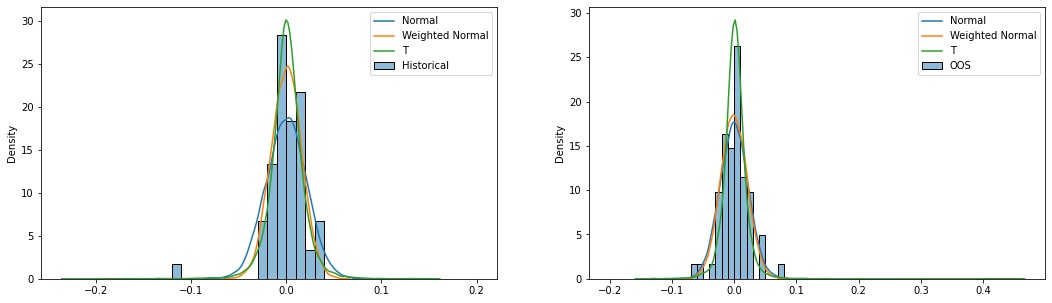

In [ ]:
show_simulation_results1(return_set, return_oos, 0.94, 5, 10000)

# Problem3

In [7]:
portfolio = pd.read_csv("portfolio.csv")
#portfolio[portfolio["Portfolio"]=="A"]
total = portfolio.groupby('Stock').sum('Holding')
total['Portfolio'] = 'total'
total.reset_index(inplace=True)
portfolio1 = portfolio.append(total)

In [8]:
portfolio1

,Portfolio,Stock,Holding
0,A,AAPL,58
1,A,TSLA,10
2,A,FB,31
3,A,JPM,64
4,A,HD,27
...,...,...,...
95,total,VZ,188
96,total,WFC,173
97,total,WMT,69
98,total,XOM,140


In [9]:
prices = pd.read_csv("DailyPrices.csv",index_col=0)
current = pd.DataFrame({"Price":prices.iloc[-1]})

In [10]:
return_set = prices.pct_change().dropna()

In [11]:
def test_normality(df, alpha):
  test_stat, p = scipy.stats.shapiro(df)
  if p >= alpha:
    return True 
  else: 
    return False 

In [12]:
def Historical_VaR(portfolio, price, alpha):
  portfolio = portfolio.set_index('Stock')
  current_price = pd.DataFrame({"price":price.iloc[-1]})
  portfolio = portfolio.join(current_price.loc[portfolio.index])
  history_values = price[portfolio.index] @ portfolio['Holding']
  return0 = history_values.diff().dropna()
  return -np.percentile(return0,alpha*100)

In [17]:
def DeltaNormal_VaR(portfolio, price, alpha):
  portfolio = portfolio.set_index('Stock')
  current_price = pd.DataFrame({"price":price.iloc[-1]})
  portfolio = portfolio.join(current_price.loc[portfolio.index])
  portfolio["Value"] = portfolio['Holding'] * portfolio['price']
  PV = portfolio["Value"].sum()
  portfolio["Weight"] = portfolio["Value"] / PV
  weight = portfolio["Weight"]
    
  return_all = price.pct_change().dropna()
  port_sigma = np.sqrt(weight.T @ return_all[portfolio.index].cov() @ weight)
    
  return -PV*port_sigma*norm.ppf(alpha)

In [15]:
def cal_portfolio_return(df, prices, alpha):
  title = ["A","B","C","Total"]
  i = 0
  History_VaR = []
  for portfolio_name, portfolio_data in df.groupby('Portfolio'):
    History_VaR.append(Historical_VaR(portfolio_data, prices, alpha))
    portfolio_data = portfolio_data.set_index('Stock')
    portfolio_data = portfolio_data.join(current.loc[portfolio_data.index])
    portfolio_data['Value'] = portfolio_data['Holding'] * portfolio_data['Price']
    portfolio_data['Weight'] = portfolio_data['Value'] / sum(portfolio_data['Value'])
    portfolio_value = portfolio_data['Value'].sum()
    his_val = prices[portfolio_data.index] @ portfolio_data['Holding']
    boolean = test_normality(his_val, alpha)
    print(f"Normality: {boolean}")

    d = pd.DataFrame(his_val,columns = ["KDE of portfolio " + title[i]])
    d.plot.kde()
    i+=1

  results = pd.DataFrame({"Historical_VaR":History_VaR},index =title).T
  
  return results

Normality: True
Normality: False
Normality: False
Normality: True


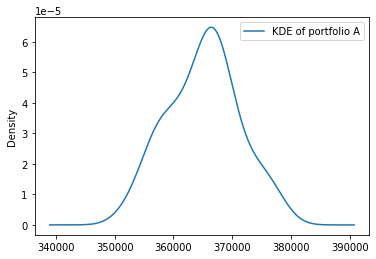

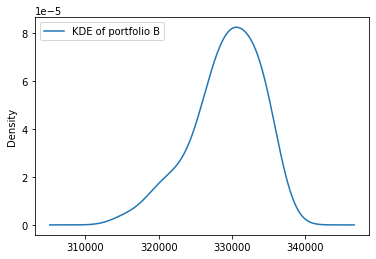

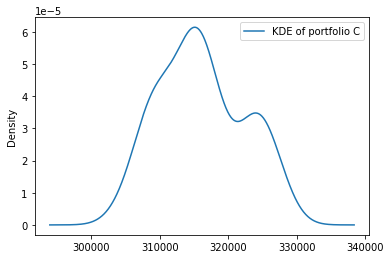

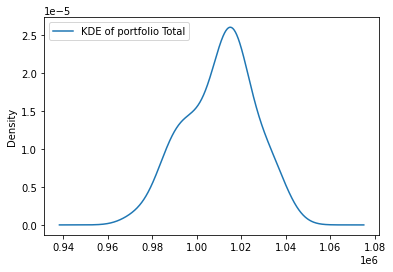

In [16]:
results = cal_portfolio_return(portfolio1, prices, 0.05)

In [18]:
results

,A,B,C,Total
Historical_VaR,5610.072337,5664.361566,3163.626064,12697.538762
